In [52]:
import pandas as pd
import numpy as  np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from datetime import datetime
import statsmodels.api as sm
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import pmdarima as pm
from Modules.Technical_indicators import ATR, BB, RSI, ADX, MACD
from sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("D:\Time_series_project\BTC-USD.csv")
df["Date"] = pd.to_datetime(df["Date"])
df_time = df.set_index(df["Date"])
df_monthly = df_time.resample('B').mean()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3503 entries, 0 to 3502
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       3503 non-null   datetime64[ns]
 1   Open       3503 non-null   float64       
 2   High       3503 non-null   float64       
 3   Low        3503 non-null   float64       
 4   Close      3503 non-null   float64       
 5   Adj Close  3503 non-null   float64       
 6   Volume     3503 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 191.7 KB


In [3]:
df["Year"] = df["Date"].dt.year

In [4]:
fig = px.line(df, x='Date', y='Adj Close', color='Year', title='Time Series Data Year-wise', 
              labels={'Adj Close': 'Adjusted Close', 'Date': 'Date'}, 
              template='plotly_dark')
fig.update_xaxes(title_text='Date')
fig.update_yaxes(title_text='Adjusted Close')
fig.show()

![alt text](1.png)

In [48]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Year,macd_signal,MB,UB,LB,BB_width,ATR,RSI,ADX
3498,2024-04-15,65739.648438,66878.648438,62332.070313,63426.210938,63426.210938,43595917654,2024,690.606419,67138.540737,72546.759081,61730.322393,10816.436688,4308.010600,33.927284,30.073956
3499,2024-04-16,63419.296875,64355.667969,61716.402344,63811.863281,63811.863281,42847528078,2024,471.892802,66377.518973,71942.524384,60812.513563,11130.010822,3890.824356,36.003895,31.304187
3500,2024-04-17,63831.847656,64486.363281,59768.585938,61276.691406,61276.691406,41915247049,2024,217.331381,65047.348772,70398.026060,59696.671485,10701.354574,4097.562603,29.011040,34.663581
3501,2024-04-18,61275.316406,64125.687500,60833.480469,63512.753906,63512.753906,36006307335,2024,-11.174489,64111.940848,67592.445052,60631.436644,6961.008408,3896.223710,40.835688,37.183127
3502,2024-04-19,63509.769531,63509.769531,59698.507813,62001.316406,62001.316406,44130336768,2024,-235.459223,63369.862165,66019.790478,60719.933852,5299.856626,3874.983212,36.094458,40.560279


### Time Series Stationarity check

In [5]:
from statsmodels.tsa.stattools import kpss, adfuller
print("KPSS (Kwiatkowski-Phillips-Schmidt-Shin) Test")
print("   Null hypothesis for this test is - Series is stationary \n   Alternative hypothesis for this test is - Series is not stationary")
ststs,p,lags, critical_values = kpss(df_monthly['Adj Close'],'ct')
print(f"      Test Statistics : {ststs}")
print(f"      P-value : {p}")
print(f"      Critical values : {critical_values}")
if p<0.05:
    print("Series is not stationary")
else:
    print("Series is stationary")
print("------------------------------------------------------------------------------------")
print("ADF (Augmented Dickey-Fuller) Test")
print("   Null Hypothesis- Series possesses a unit root and hence is not stationary \n   Alternate Hypothesis - Series is stationary")

result = adfuller(df_monthly['Adj Close'])
print(f"      Test Statistics : {result[0]}")
print(f"      P-value : {result[1]}")
print(f"      Critical values : {result[4]}")
if result[1]>0.05:
    print("Series is not stationary")
else:
    print("Series is stationary")

KPSS (Kwiatkowski-Phillips-Schmidt-Shin) Test
   Null hypothesis for this test is - Series is stationary 
   Alternative hypothesis for this test is - Series is not stationary
      Test Statistics : 0.3586790249335492
      P-value : 0.01
      Critical values : {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}
Series is not stationary
------------------------------------------------------------------------------------
ADF (Augmented Dickey-Fuller) Test
   Null Hypothesis- Series possesses a unit root and hence is not stationary 
   Alternate Hypothesis - Series is stationary
      Test Statistics : -0.9457360125350205
      P-value : 0.7725381830801121
      Critical values : {'1%': -3.4329938176251593, '5%': -2.8627080196071697, '10%': -2.567391782912405}
Series is not stationary


C:\Users\aakas\AppData\Local\Temp\ipykernel_15476\3857031858.py:4: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




### Time Series Decomposition  (original, trend, seasonal, and residual)

In [6]:
res = sm.tsa.seasonal_decompose(
    df_monthly['Adj Close'],
    model = 'multiplicative'
)
fig = make_subplots(rows=4, cols=1, shared_xaxes=True, vertical_spacing=0.01)

trace_original = fig.add_trace(go.Scatter(x=df_monthly.index, y=df_monthly['Adj Close'], mode='lines', name='Original'), row=1, col=1)
trace_trend = fig.add_trace(go.Scatter(x=df_monthly.index, y=res.trend, mode='lines', name='Trend'), row=2, col=1)
trace_seasonal = fig.add_trace(go.Scatter(x=df_monthly.index, y=res.seasonal, mode='lines', name='Seasonal'), row=3, col=1)
trace_residual = fig.add_trace(go.Scatter(x=df_monthly.index, y=res.resid, mode='lines', name='Residual'), row=4, col=1)

fig.update_layout(title='Seasonal Decomposition using Plotly',
                   xaxis_title='Date',
                   yaxis_title='Value')

fig.update_yaxes(title_text='Original', row=1, col=1)
fig.update_yaxes(title_text='Trend', row=2, col=1)
fig.update_yaxes(title_text='Seasonal', row=3, col=1)
fig.update_yaxes(title_text='Residual', row=4, col=1)
fig.update_layout(
        #xaxis=dict(rangeslider=dict(visible=True)),
        height=1400,
        xaxis4=dict(
            rangeslider=dict(visible=True),
            type="date"
            ,
            range=[df_monthly.index.max() - pd.Timedelta(days = 90), df_monthly.index.max() ]  # Display one year initially
        )
    )
fig.update_layout(title='Seasonal Decomposition using Plotly',
                  xaxis_title='Date',
                  xaxis=dict(rangeselector=dict(
                      buttons=list([
                          dict(count=6, label="6m", step="month", stepmode="backward"),
                          dict(count=1, label="YTD", step="year", stepmode="todate"),
                          dict(count=1, label="1y", step="year", stepmode="backward"),
                          dict(step="all")
                      ])
                  ),
                               type="date")
                  )
fig.show()

![alt text](trend.png)

In [10]:
def apply_technical_indicators(df):
    df = MACD(df)
    df = BB(df)
    df = ATR(df)
    df['RSI'] = RSI(df)
    df['ADX']= ADX(df)
    return df
df = apply_technical_indicators(df)

In [14]:
df.dropna(inplace= True)

The residual component typically contains information about irregular or unpredictable fluctuations in the data, such as short-term fluctuations, outliers, or measurement errors. Analyzing the residual component can help identify any remaining patterns or anomalies in the data that are not captured by the trend or seasonal components.

### Granger Causality Test for Usefullness of Time Series in Forecasting
The Granger causality test is a statistical hypothesis test used to determine whether one time series is useful in forecasting another. It is based on the idea that if a time series 𝑋 "Granger-causes" another time series Y, then past values of  X should contain information that helps predict the current or future values of Y beyond what can be predicted using past values of 𝑌 alone.                                

The Granger causality test involves fitting a regression model for each time series separately and then comparing the performance of these models with and without lagged values of the potential causal variable. The null hypothesis of the test is that the lagged values of the potential causal variable do not provide any additional predictive power beyond what is already captured by lagged values of the dependent variable.

In [28]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Year',
       'macd_signal', 'MB', 'UB', 'LB', 'BB_width', 'ATR', 'RSI', 'ADX'],
      dtype='object')

In [34]:
from statsmodels.tsa.stattools import grangercausalitytests
max_legs  = 4
results_macd_signal =  grangercausalitytests(df[['Adj Close','macd_signal']], max_legs, verbose =False)
p_values = [round(results_macd_signal[i+1][0]['ssr_ftest'][1],max_legs) for i in range(max_legs)]
print('P Values per legs - ' + str(p_values))

P Values per legs - [0.0405, 0.076, 0.0025, 0.0429]



A common significance level used in statistical tests is 0.05. If a p-value is less than 0.05, it is considered statistically significant. Based on this criterion:               
- At lag 1, the p-value is 0.0405, which is close to the significance level. It suggests some evidence of causality.         
- At lag 2, the p-value is 0.076, which is higher but still relatively close to 0.05. It indicates some evidence but weaker compared to lag 1.                      
- At lag 3, the p-value is 0.0025, which is well below 0.05. This suggests strong evidence of causality.              
- At lag 4, the p-value is 0.0429, again close to the significance level, indicating some evidence of causality.             

Based on these results, there seems to be some evidence supporting the use of the macd_signal feature for forecasting the Adj Close variable, especially at lag 3 where the evidence of causality is stronger. However, it's important to consider other factors such as model performance metrics, economic theory, and domain knowledge before making a final decision on feature inclusion.

In [42]:
features = ['macd_signal', 'BB_width', 'ATR', 'RSI', 'ADX']
max_legs  = 4
for i in features:
    results =  grangercausalitytests(df[['Adj Close',i]], max_legs, verbose =False)
    p_values = [round(results[i+1][0]['ssr_ftest'][1],max_legs) for i in range(max_legs)]
    print(i)
    print(f' P Values per legs with {i}- ' + str(p_values))
    print("-----------------------------------------------------------------")

macd_signal
 P Values per legs with macd_signal- [0.0405, 0.076, 0.0025, 0.0429]
-----------------------------------------------------------------
BB_width
 P Values per legs with BB_width- [0.162, 0.0, 0.0001, 0.0]
-----------------------------------------------------------------
ATR
 P Values per legs with ATR- [0.9613, 0.5447, 0.5677, 0.7495]
-----------------------------------------------------------------
RSI
 P Values per legs with RSI- [0.0641, 0.0028, 0.0105, 0.0517]
-----------------------------------------------------------------
ADX
 P Values per legs with ADX- [0.0329, 0.0094, 0.0137, 0.0379]
-----------------------------------------------------------------


### Correaltion Matrix 

In [40]:
df[['Adj Close','macd_signal', 'BB_width', 'ATR', 'RSI', 'ADX']].corr()

,Adj Close,macd_signal,BB_width,ATR,RSI,ADX
Adj Close,1.000000,0.312444,0.785718,0.866801,0.009515,-0.110238
macd_signal,0.312444,1.000000,0.244631,0.252745,0.304386,0.073235
BB_width,0.785718,0.244631,1.000000,0.898724,-0.007455,0.052979
ATR,0.866801,0.252745,0.898724,1.000000,-0.062669,-0.013990
RSI,0.009515,0.304386,-0.007455,-0.062669,1.000000,0.346330
ADX,-0.110238,0.073235,0.052979,-0.013990,0.346330,1.000000


## Anomaly Detection in time series
Anomaly detection in time series involves identifying unusual patterns or observations that deviate from the expected behavior over time. These anomalies, also known as outliers, can represent data points that are significantly different from the majority of the data and may indicate important events, errors, or changes in the underlying process.
### Using Prophet

In [77]:
from prophet import Prophet

train_df = df[['Date', 'Adj Close']].rename({'Date':'ds' , 'Adj Close': 'y'}, axis = 'columns')
train_df

,ds,y
33,2014-10-20,382.845001
34,2014-10-21,386.475006
35,2014-10-22,383.157990
36,2014-10-23,358.416992
37,2014-10-24,358.345001
...,...,...
3498,2024-04-15,63426.210938
3499,2024-04-16,63811.863281
3500,2024-04-17,61276.691406
3501,2024-04-18,63512.753906


In [102]:
Model = Prophet(changepoint_range = 0.90)
Model.fit(train_df)

17:49:12 - cmdstanpy - INFO - Chain [1] start processing
17:49:12 - cmdstanpy - INFO - Chain [1] done processing


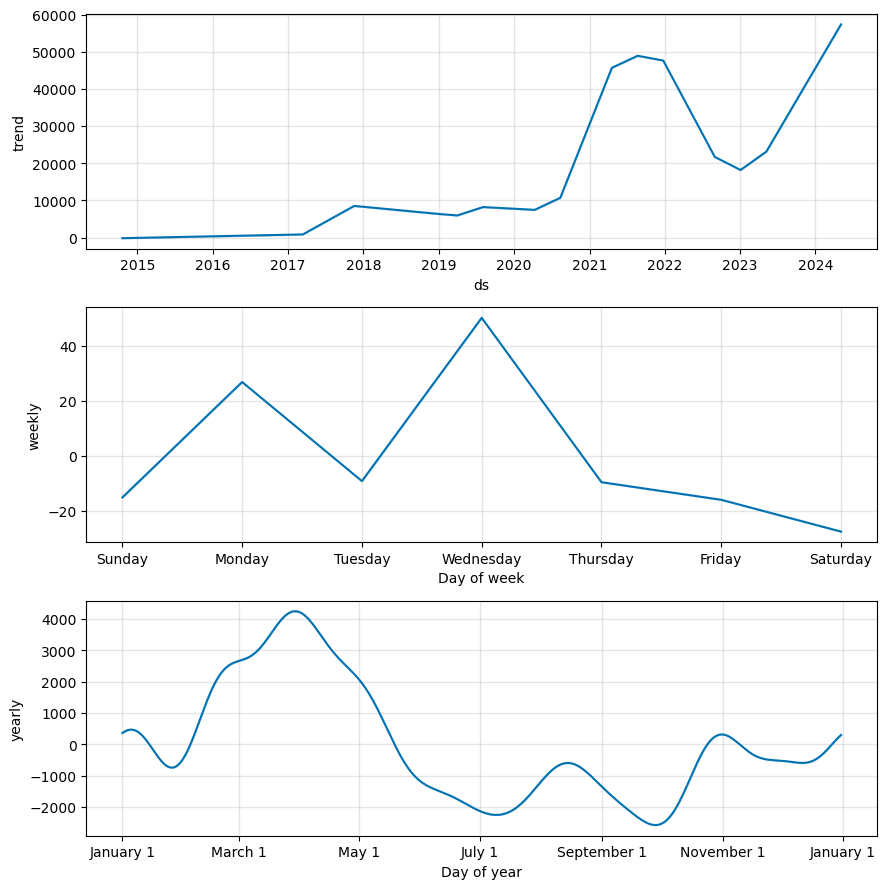

In [103]:
future = Model.make_future_dataframe(periods = 15, freq = 'D')
forecast = Model.predict(future)

results = pd.concat([train_df.set_index('ds')['y'], forecast.set_index('ds')[['yhat','yhat_lower', 'yhat_upper']]] , axis = 1)
x = Model.plot_components(forecast)

In [104]:
results.dropna(inplace = True)

In [105]:
results['error'] = results['y'] - results['yhat']
results['uncertainity'] = results['yhat_upper'] - results['yhat_lower']
results['anomaly'] = results.apply(lambda x: 'Yes' if (np.abs(x['error']) > 1.5* x['uncertainity']) else 'No' , axis = 1)
results['anomaly'].value_counts()

anomaly
No     3455
Yes      15
Name: count, dtype: int64

In [115]:
fig = px.scatter(results.reset_index(), x = 'ds', y = 'y', color = 'anomaly', title = 'Anomaly Detection',template='plotly_dark')
fig.update_layout(
        #xaxis=dict(rangeslider=dict(visible=True)),

        xaxis=dict(
            rangeslider=dict(visible=True),
            type="date"
            ,
            range=[df_time.index.max() - pd.Timedelta(days = 1095), df_time.index.max() ]  # Display one year initially
        )
    )
fig.show()

![alt text](2.png)